# Marks DM Profile Creator

Based on Chris Kiehl's original work.

In [17]:
from matplotlib.pyplot import *
import matplotlib.image as mpimg
import matplotlib.colors as colors
from matplotlib.patches import Circle, PathPatch
import scipy.integrate as integrate
import numpy as np
from scipy.optimize import curve_fit
import cmath
import csv
from numpy import array as arr
from copy import copy
from scipy.special import factorial 
%matplotlib inline

In [2]:
def getKnoll(n,m):
    return (n*(n+2)+m)/2
def fromNoll(j):
    n = 0
    m = 0
    while (j > n):
        n += 1
        j -= n
    m = -n+2*j
    return n,m
# make sure these are inverses.
for j in range(200):
    if j != getKnoll(*fromNoll(j)):
        print('!')

In [3]:
from numpy import array as arr

In [4]:
def toPolar(x,y):
    r = np.sqrt(x**2+y**2)
    phi = np.arctan2(y,x)
    return r,phi
def toCartesian(r,theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x,y
# make sure these are inverses
for x in np.linspace(-1,1,100):
    for y in np.linspace(-1,1,100):
        if (arr((x,y)) -arr(toCartesian(*toPolar(x,y)))>1e-9).any():
            print('!')

In [5]:
def zernikeTheta(m,theta):
    if (m >= 0):
        return np.cos(m*theta)
    else:
        return np.sin(-m*theta)
def zernikeRadial(n,m,r):
    m = abs(m)
    if (m > n):
        print('Error: n must be greater than or equal to n!')
        return 0
    if (((n-m)%2) > 0):
        print('Error: (n - m) must be even!')
        return 0
    kArray = np.linspace(0,(n-m)/2,int((n-m)/2+1))
    rArray = 0
    i = 0
    for k in kArray:
        rArray=rArray+(r**(n-2*k))*((-1)**k)*factorial(n-k)/(factorial(k)*factorial((n+m)/2-k)*factorial((n-m)/2-k))
        i = i+1
    return rArray
def normalization(n,m):
    """ Unused? I think the normalization is built in"""
    if (m == 0) :
        a = 2*np.pi
    else:
        a = 1*np.pi
    return np.sqrt((2*n+2)/a)
# put the above together.
def zernike(n,m,x,y):
    return zernikePolar(n,m,*toPolar(x,y))
    #r,theta = polar(x,y)
    #return zernikeTheta(m,theta)*zernikeRadial(n,m,r)*normalization(n,m)
def zernikePolar(n,m,r,theta):
    return zernikeTheta(m,theta)*zernikeRadial(n,m,r)*normalization(n,m)

In [6]:
def zernikeFit(X,*param):
    x,y = X
    height = param[0]*zernike(fromNoll(0)[0],fromNoll(0)[1],x,y)
    for k in range(1,41):
        height += param[k]*zernike(fromNoll(k)[0],fromNoll(k)[1],x,y)
    return height

## Verifying Orthogonality

In [7]:
n = 5
m = 1
#def integrand(r,theta):
 #   return r*zernikePolar(n,m,r,theta)**2
f = lambda theta, r: r*zernikePolar(4,0,r,theta)*zernikePolar(4,2,r,theta)
# should be small, presumably.
print(integrate.dblquad(f, 0, 1, lambda r: 0, lambda r: 2*np.pi))

(-7.243814608430614e-17, 9.871058785287423e-09)


## DM Lookup Table

In [8]:
def myDmLookup(pixNum, factor=1/3.0):
    if not (0 <= pixNum <= 136):
        raise ValueError('Invalid Pixel Number!')
    rowOff = [4,2,1,1,0,0,0,0,0,1,1,2,4]
    numInRow = []
    yInit = 6
    for rowOffset in rowOff:
        numInRow.append((7-(rowOffset+1))*2+1)
    #sum(numInRow) = 137
    centerOffset = -((arr(numInRow)-1)/2).astype(int)
    pn = copy(pixNum)
    for rowNum, num in enumerate(numInRow):
        pn -= num
        if pn < 0:
            pn += num
            return [factor*(centerOffset[rowNum]+pn), factor*(yInit-rowNum)]
    raise ValueError('ERROR: Somehow made it to the end of the loop depsite passing the initial value range check...')

## Program Pure Zernike Polynomials

In [9]:
import os

In [10]:
def readZernikeFile(file):
    valArray = []
    with open(file) as f:
        lines = f.readlines()
        for l in lines:
            valArray.append(float(l))
    return valArray

In [11]:
def writeZernikeFile(valArray, outFile):
    # not sure if any need to do this slightly more convoluted writing, but just copying chris's method.
    with open(outFile, 'w', newline='') as csvfile:
        DM_Writer = csv.writer(csvfile, delimiter=' ', quotechar ='|', quoting=csv.QUOTE_MINIMAL)
        for v in valArray:
            DM_Writer.writerow([v])

In [12]:
def makeIm(actuatorValueList):
    avl = actuatorValueList
    pic = np.zeros((13,13))+0.5
    rowOff = [4,2,1,1,0,0,0,0,0,1,1,2,4]
    tc = 0
    for i, rowO in enumerate(rowOff):
        numInRow = (7-(rowO+1))*2+1
        for j in range(numInRow):
            pic[i][rowO+j] = avl[tc]
            tc += 1
    return pic

In [13]:
def addComa(zAmps, comaMag, comaAngle):
    """
    Adds at a particular angle and magnitude to a list of zernike amplituders.
    """
    x,y = toCartesian(comaMag,comaAngle)
    zAmps[7] += x
    zAmps[8] += y
    return zAmps

In [19]:
def createZernikeArray(amplitudes, baselineFile):
    vals = []
    inc = 1/3
    flatVoltage = np.linspace(0, 136, 137)
    newVoltage = np.linspace(0, 136, 137)
    sign=0
    with open(baselineFile, newline='') as csvfile:
        DM_Reader = csv.reader(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_NONNUMERIC)
        for i, row in enumerate(DM_Reader):
            flatVoltage[i]=row[0]
    for i in range(0,137):
        zernSum=0
        weightFactor = 1
        x,y = myDmLookup(i)
        if (x**2+y**2)<=1:
            for j, amp in enumerate(amplitudes):
                m,n = fromNoll(j)
                zernSum += amp*zernike(m,n,x,y)
        elif (x**2+y**2)<1.5:
            for j, amp in enumerate(amplitudes):
                m,n = fromNoll(j)
                r,t = toPolar(x,y)
                # use circle's edge (i.e. r=1) value at the angle of the pixel
                x_, y_ = toCartesian(1,t)
                zernSum += amp*zernike(m,n,x_,y_)
        volt = (-1 if zernSum <= 0 else 1)*zernSum**2*weightFactor+flatVoltage[i]
        if not (0 < volt < 1):
            print('Voltage out of range! Actuator: ', i,', Value:',volt)
        vals.append(volt)
    return vals

In [20]:
vals_old = readZernikeFile('coma_test---.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'coma_test---.txt'

### piston (seeing used area)

In [21]:
currentAmps = np.linspace(0,0,45) 
mag = 0.2
vals_base = createZernikeArray(np.zeros(45), '25CW012#060_CLOSED_LOOP_COMMANDS.txt')
currentAmps[0] = 0.2
vals_pist = writeZernikeFile(createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), outFile)

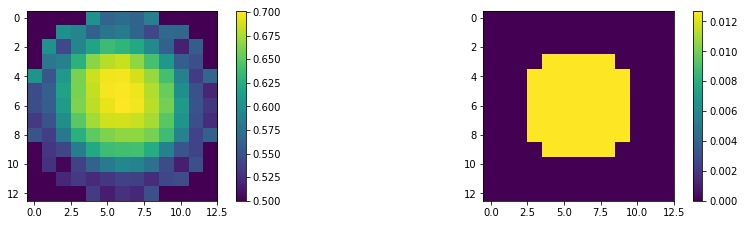

In [22]:
f, ax = subplots(1,2,figsize=(15,3.5))
im = ax[0].imshow(makeIm(vals_pist))
colorbar(im, ax=ax[0])
diffNew = makeIm(vals_pist)-makeIm(vals_base)
im = ax[1].imshow(diffNew)
colorbar(im, ax=ax[1])
#colorbar()

### coma

In [23]:
currentAmps = np.linspace(0,0,45) 
mag = 0.2
vals_base = createZernikeArray(np.zeros(45), '25CW012#060_CLOSED_LOOP_COMMANDS.txt')
vals_new = createZernikeArray(addComa(currentAmps,0.2,np.pi/6), '25CW012#060_CLOSED_LOOP_COMMANDS.txt')
currentAmps = np.linspace(0,0,45) 
currentAmps[7] = 0.2
vals_vert = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt')

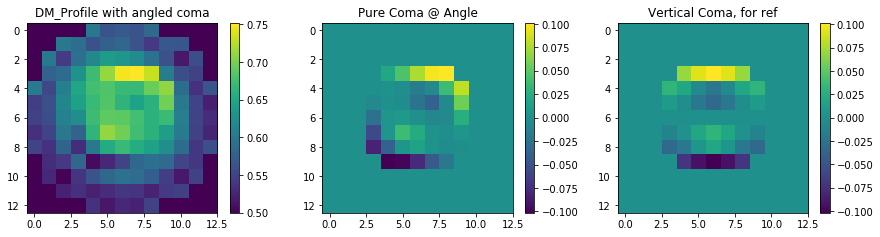

In [24]:
f, ax = subplots(1,3,figsize=(15,3.5))
im = ax[0].imshow(makeIm(vals_new))
colorbar(im, ax=ax[0])
diffNew = makeIm(vals_new)-makeIm(vals_base)
ax[0].set_title('DM_Profile with angled coma')
im = ax[1].imshow(diffNew)
colorbar(im, ax=ax[1])
ax[1].set_title('Pure Coma @ Angle')
diffvert = makeIm(vals_vert)-makeIm(vals_base)
im = ax[2].imshow(diffvert)
ax[2].set_title('Vertical Coma, for ref')
#im = ax[2].imshow(diffHor,vmax=max(diffNew.flatten()),vmin=min(diffNew.flatten()))
colorbar(im, ax=ax[2])

#colorbar()

### spherical

In [169]:
getKnoll(4,0)

12.0

In [185]:
currentAmps = np.linspace(0,0,45) 
mag = 0.2
vals_base = createZernikeArray(np.zeros(45), '25CW012#060_CLOSED_LOOP_COMMANDS.txt')
currentAmps[12] = 0.2
vals_new = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt')

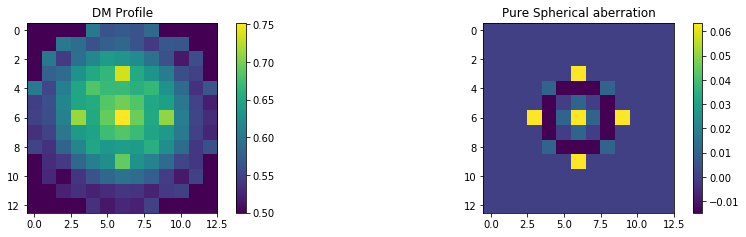

In [187]:
f, ax = subplots(1,2,figsize=(15,3.5))
im = ax[0].imshow(makeIm(vals_new))
colorbar(im, ax=ax[0])
ax[0].set_title('DM Profile')
diffNew = makeIm(vals_new)-makeIm(vals_base)
im = ax[1].imshow(diffNew)
ax[1].set_title('Pure Spherical aberration')
colorbar(im, ax=ax[1])
#colorbar()

Doesn't look like spherical. Boundaries just look bad.

# Scan 1: Coma rotation:

In [29]:
import sys
sys.path.insert(0, "..")

In [30]:
import Miscellaneous as misc

In [31]:
for theta in np.arange(0,2*np.pi,0.1):
    currentAmps = np.zeros(45)
    writeZernikeFile(createZernikeArray(addComa(currentAmps,0.2,theta), '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan1_'+misc.round_sig_str(theta)+'.txt')

# Scan 2: Coma Magnitude

At theta = 3pi/2

In [39]:
for mag in np.arange(0,0.4,0.05):
    print('.',end='')
    currentAmps = np.zeros(45)
    writeZernikeFile(createZernikeArray(addComa(currentAmps,mag,3*np.pi/2), '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan2_'+misc.round_sig_str(mag)+'.txt')

........